#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 8 #37 #98 #190 #61 #37 #46
# N_CLASSES= 9
TIMESTEPS = 1
EPOCH=500
BATCH_SIZE=1000

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset"
SAMPLE_DATASET_NAME = "five_train_class" + ".csv"
ACTUAL_DATASET_NAME = "five_test_class" + ".csv"

# SAMPLE_DATASET_NAME = "train_m2m_tengraph" + ".csv"
# ACTUAL_DATASET_NAME = "test_m2m_tengraph" + ".csv"

# SAMPLE_DATASET_NAME = "andy" + ".csv"
# ACTUAL_DATASET_NAME = "andy" + ".csv"

MODEL_DIR_NAME = "model"
MODEL_NAME = "classifier" + ".h5"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 4 #4
CLASS_LIST = ['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']
# CLASS_LIST = ['andy', 'azfar', 'gerald', 'jonah', 'ys']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

def df_drop(df):
    # df.drop(df[df['Subject']=='andy'].index, inplace=True)
    # df.drop(df[df['Subject']=='azfar'].index, inplace=True)
    df.drop(df[df['Subject']=='ch'].index, inplace=True)
    # df.drop(df[df['Subject']=='cy'].index, inplace=True)
    df.drop(df[df['Subject']=='gerald'].index, inplace=True)
    df.drop(df[df['Subject']=='jc'].index, inplace=True)
    df.drop(df[df['Subject']=='jonah'].index, inplace=True)
    df.drop(df[df['Subject']=='qikai'].index, inplace=True)
    df.drop(df[df['Subject']=='ys'].index, inplace=True)
    df.drop(df[df['Subject']=='zen'].index, inplace=True)
    
    return df

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\dataset
Model directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\model


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
# create base model
def create_base_model():
    model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, 
#                  input_shape=(TIMESTEPS,N_FEATURES)))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    model.add(LSTM(units=1024, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model



In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### CHECK DATASET

In [7]:
#     sns.catplot(x="Subject", y="D|0", data=df)

    
#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|3", hue="D|3", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|4", hue="D|4", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|5", hue="D|5", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|6", hue="D|6", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|7", hue="D|7", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|8", hue="D|8", data=df, legend=False)

#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="I|1+2", hue="I|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="PF|1+2", hue="PF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="RF|1+2", hue="RF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="DT|1+2", hue="DT|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|9", hue="D|9", data=df, legend=False)


#     sns.catplot(x="Subject", y="TT|1+3", hue="TT|1+3", data=df, legend=False)
#     sns.catplot(x="Subject", y="QT|1+4", hue="QT|1+4", data=df, legend=False)

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [8]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

# df = df_drop(df)
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (9360, 8)
Y | Classes  | Dataset Shape: (9360, 10)
10
Epoch 1/500
10/10 [==============================] - 17s 316ms/step - loss: 2.3049 - accuracy: 0.0888
Epoch 2/500
10/10 [==============================] - 3s 300ms/step - loss: 2.3045 - accuracy: 0.0957
Epoch 3/500
10/10 [==============================] - 3s 320ms/step - loss: 2.3034 - accuracy: 0.1035
Epoch 4/500
10/10 [==============================] - 3s 319ms/step - loss: 2.3039 - accuracy: 0.0935
Epoch 5/500
10/10 [==============================] - 3s 298ms/step - loss: 2.3014 - accuracy: 0.1096
Epoch 6/500
10/10 [==============================] - 3s 283ms/step - loss: 2.2835 - accuracy: 0.1300
Epoch 7/500
10/10 [==============================] - 3s 300ms/step - loss: 2.2481 - accuracy: 0.1565
Epoch 8/500
10/10 [==============================] - 3s 343ms/step - loss: 2.1969 - accuracy: 0.17

10/10 [==============================] - 4s 365ms/step - loss: 1.5568 - accuracy: 0.4154
Epoch 80/500
10/10 [==============================] - 3s 312ms/step - loss: 1.5583 - accuracy: 0.4153
Epoch 81/500
10/10 [==============================] - 3s 316ms/step - loss: 1.5580 - accuracy: 0.4128
Epoch 82/500
10/10 [==============================] - 3s 315ms/step - loss: 1.5415 - accuracy: 0.4259
Epoch 83/500
10/10 [==============================] - 4s 390ms/step - loss: 1.5334 - accuracy: 0.4314
Epoch 84/500
10/10 [==============================] - 4s 390ms/step - loss: 1.5239 - accuracy: 0.4247
Epoch 85/500
10/10 [==============================] - 4s 358ms/step - loss: 1.5248 - accuracy: 0.4262
Epoch 86/500
10/10 [==============================] - 4s 376ms/step - loss: 1.5200 - accuracy: 0.4271
Epoch 87/500
10/10 [==============================] - 3s 330ms/step - loss: 1.5106 - accuracy: 0.4301
Epoch 88/500
10/10 [==============================] - 3s 322ms/step - loss: 1.4848 - accuracy: 

10/10 [==============================] - 4s 360ms/step - loss: 1.0717 - accuracy: 0.6024
Epoch 159/500
10/10 [==============================] - 4s 360ms/step - loss: 1.0771 - accuracy: 0.5986
Epoch 160/500
10/10 [==============================] - 4s 362ms/step - loss: 1.0720 - accuracy: 0.6062
Epoch 161/500
10/10 [==============================] - 4s 352ms/step - loss: 1.0485 - accuracy: 0.6174
Epoch 162/500
10/10 [==============================] - 4s 360ms/step - loss: 1.0565 - accuracy: 0.6122
Epoch 163/500
10/10 [==============================] - 4s 360ms/step - loss: 1.0517 - accuracy: 0.6105
Epoch 164/500
10/10 [==============================] - 4s 366ms/step - loss: 1.0486 - accuracy: 0.6078
Epoch 165/500
10/10 [==============================] - 4s 361ms/step - loss: 1.0452 - accuracy: 0.6170
Epoch 166/500
10/10 [==============================] - 4s 369ms/step - loss: 1.0291 - accuracy: 0.6183
Epoch 167/500
10/10 [==============================] - 4s 357ms/step - loss: 1.0557 - a

10/10 [==============================] - 4s 431ms/step - loss: 0.7900 - accuracy: 0.7049
Epoch 238/500
10/10 [==============================] - 4s 443ms/step - loss: 0.7766 - accuracy: 0.7150
Epoch 239/500
10/10 [==============================] - 4s 371ms/step - loss: 0.7770 - accuracy: 0.7172
Epoch 240/500
10/10 [==============================] - 4s 366ms/step - loss: 0.7922 - accuracy: 0.7118
Epoch 241/500
10/10 [==============================] - 4s 370ms/step - loss: 0.7669 - accuracy: 0.7215
Epoch 242/500
10/10 [==============================] - 4s 368ms/step - loss: 0.7969 - accuracy: 0.7097
Epoch 243/500
10/10 [==============================] - 4s 371ms/step - loss: 0.7651 - accuracy: 0.7194
Epoch 244/500
10/10 [==============================] - 4s 366ms/step - loss: 0.7679 - accuracy: 0.7202
Epoch 245/500
10/10 [==============================] - 4s 373ms/step - loss: 0.7726 - accuracy: 0.7158
Epoch 246/500
10/10 [==============================] - 4s 365ms/step - loss: 0.7911 - a

10/10 [==============================] - 3s 324ms/step - loss: 0.6393 - accuracy: 0.7690
Epoch 317/500
10/10 [==============================] - 3s 317ms/step - loss: 0.6284 - accuracy: 0.7692
Epoch 318/500
10/10 [==============================] - 3s 314ms/step - loss: 0.6370 - accuracy: 0.7732
Epoch 319/500
10/10 [==============================] - 3s 312ms/step - loss: 0.6114 - accuracy: 0.7718
Epoch 320/500
10/10 [==============================] - 3s 319ms/step - loss: 0.6152 - accuracy: 0.7752
Epoch 321/500
10/10 [==============================] - 3s 313ms/step - loss: 0.5821 - accuracy: 0.7916
Epoch 322/500
10/10 [==============================] - 3s 320ms/step - loss: 0.6115 - accuracy: 0.7755
Epoch 323/500
10/10 [==============================] - 3s 317ms/step - loss: 0.5869 - accuracy: 0.7833
Epoch 324/500
10/10 [==============================] - 3s 312ms/step - loss: 0.6135 - accuracy: 0.7786
Epoch 325/500
10/10 [==============================] - 3s 318ms/step - loss: 0.6083 - a

10/10 [==============================] - 3s 322ms/step - loss: 0.5090 - accuracy: 0.8162
Epoch 396/500
10/10 [==============================] - 3s 320ms/step - loss: 0.5082 - accuracy: 0.8128
Epoch 397/500
10/10 [==============================] - 3s 323ms/step - loss: 0.5103 - accuracy: 0.8151
Epoch 398/500
10/10 [==============================] - 3s 322ms/step - loss: 0.5160 - accuracy: 0.8110
Epoch 399/500
10/10 [==============================] - 3s 323ms/step - loss: 0.5315 - accuracy: 0.8057
Epoch 400/500
10/10 [==============================] - 3s 322ms/step - loss: 0.5141 - accuracy: 0.8121
Epoch 401/500
10/10 [==============================] - 3s 321ms/step - loss: 0.5361 - accuracy: 0.8059
Epoch 402/500
10/10 [==============================] - 3s 319ms/step - loss: 0.5313 - accuracy: 0.8092
Epoch 403/500
10/10 [==============================] - 3s 316ms/step - loss: 0.5850 - accuracy: 0.7919
Epoch 404/500
10/10 [==============================] - 3s 313ms/step - loss: 0.5543 - a

10/10 [==============================] - 3s 324ms/step - loss: 0.4583 - accuracy: 0.8370
Epoch 475/500
10/10 [==============================] - 3s 321ms/step - loss: 0.4590 - accuracy: 0.8381
Epoch 476/500
10/10 [==============================] - 3s 320ms/step - loss: 0.5051 - accuracy: 0.8193
Epoch 477/500
10/10 [==============================] - 3s 321ms/step - loss: 0.4808 - accuracy: 0.8260
Epoch 478/500
10/10 [==============================] - 3s 323ms/step - loss: 0.4715 - accuracy: 0.8279
Epoch 479/500
10/10 [==============================] - 3s 324ms/step - loss: 0.4857 - accuracy: 0.8255
Epoch 480/500
10/10 [==============================] - 3s 323ms/step - loss: 0.4954 - accuracy: 0.8251
Epoch 481/500
10/10 [==============================] - 3s 329ms/step - loss: 0.4613 - accuracy: 0.8281
Epoch 482/500
10/10 [==============================] - 3s 327ms/step - loss: 0.4906 - accuracy: 0.8228
Epoch 483/500
10/10 [==============================] - 3s 324ms/step - loss: 0.4680 - a

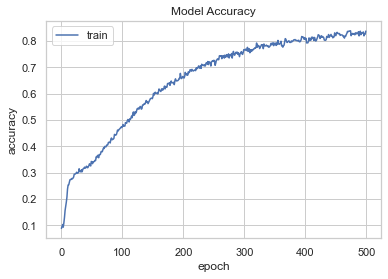

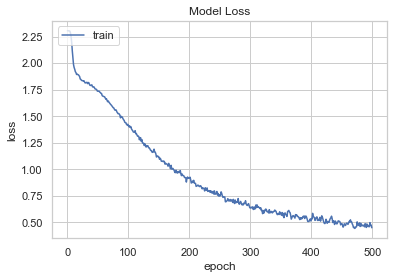

In [9]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [10]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [11]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [12]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()
# pred_df = df_drop(pred_df)

,Subject,Char_Total_Str,Seq_No,Char_Total_Int,Char_Init,Char_End,Current_Dwell,Interval,Press_Flight,Release_Flight,Digraph,Later_Dwell
0,adhy,e_r,3,5_18,5,18,0.116169,0.046851,0.163020,0.100629,0.216798,0.053778
1,adhy,r_r,3,18_18,18,18,0.053778,0.046873,0.100651,0.185100,0.238878,0.138227
2,adhy,r_~,3,18_0,18,0,0.138227,0.031387,0.169614,0.162943,0.301169,0.131556
3,adhy,~_z,3,0_26,0,26,0.131556,0.039896,0.171451,0.154139,0.285695,0.114244
4,adhy,z_a,3,26_1,26,1,0.114244,0.131671,0.245915,0.216195,0.330438,0.084523


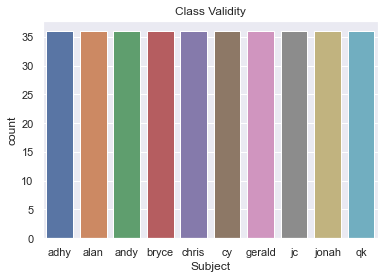

In [13]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [39]:
pred_dataset = pred_df.values
results = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
# pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

pax = 4
start = 0 + pax * 9
end = 8 + pax * 9 
print(start)
print(end)
pred_row=pred_df.iloc[start:end,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = CLASS_LIST
print(Y)
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

36
44
['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [37]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

pred_proba = np.sum(pred_proba, axis=0)
print(pred_proba)
pred_proba = np.reshape(pred_proba, (1, 10))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))
# pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

df.to_csv("results.csv")

[1.2116178e+00 1.4094448e-03 9.8499888e-01 1.1400036e+00 2.5090480e-01
 1.8490105e+00 5.7756798e-03 9.6805680e-01 1.4070252e+00 1.8119749e-01]
  Prediction   Accuracy
0         cy  1.8490105
